In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Implement neural network from scratch

In [21]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))


def softmax(X):
    """assume that X has shape (batch_size, n_classes)"""
    assert X.ndim == 2, "X must be a 2D array"
    X_exp = np.exp(X - X.max(axis=1, keepdims=True))
    norm_factor = X_exp.sum(axis=1, keepdims=True)
    return X_exp / norm_factor


def cross_entropy(y_hat, y):
    assert y_hat.ndim == 2, "y_hat must be 2D array"
    assert y_hat.shape == y.shape, "y_hat and y must have same shape"
    
    y = y.argmax(axis=1)
    idx0 = range(y_hat.shape[0])
    return -np.mean(np.log(y_hat[idx0, y]))


def weight_initializer(n_inputs, n_units):
    alpha = 1 / np.sqrt(n_inputs)
    return np.random.uniform(low=-alpha, high=alpha, size=(n_inputs, n_units))


def bias_initializer(n_inputs, n_units):
    alpha = 1 / np.sqrt(n_inputs)
    return np.random.uniform(low=-alpha, high=alpha, size=(1, n_units))

In [22]:
def data_generator(X, y, batch_size=32):
    assert X.shape[0] == y.shape[0], "X and y must have the same first shape"
    
    nsamples = X.shape[0]
    idx = np.arange(nsamples)
    np.random.shuffle(idx)
    
    niter = nsamples // batch_size
    for i in range(niter):
        lower = i * batch_size
        upper = (i + 1) * batch_size
        yield X[lower: upper], y[lower: upper]

In [28]:
def feedforward(X, 
                W_1, b_1, 
                W_2, b_2, 
                W_o, b_o):
    Z_1 = X.dot(W_1) + b_1
    H_1 = sigmoid(Z_1)
    
    Z_2 = H_1.dot(W_2) + b_2
    H_2 = sigmoid(Z_2)
    
    Z_o = H_2.dot(W_o) + b_o
    y_hat = softmax(Z_o)
    
    return H_1, H_2, y_hat


def predict(X, 
            W_1, b_1, 
            W_2, b_2, 
            W_o, b_o):
    _, _, y_hat = feedforward_(X, W_1, b_1, W_2, b_2, W_o, b_o)
    return y_hat


def backpropagation(X, y, y_hat, W_o, W_2, H_2, H_1):
    delta_o = y_hat - y
    dL_dW_o = H_2.T.dot(delta_o)
    dL_db_o = delta_o.sum(axis=0, keepdims=True)
    
    delta_2 = delta_o.dot(W_o.T) * H_2 * (1 - H_2)
    dL_dW_2 = H_1.T.dot(delta_2)
    dL_db_2 = delta_2.sum(axis=0, keepdims=True)
    
    delta_1 = delta_2.dot(W_2.T) * H_1 * (1 - H_1)
    dL_dW_1 = X.T.dot(delta_1)
    dL_db_1 = delta_1.sum(axis=0, keepdims=True)
    
    return dL_dW_o, dL_db_o, dL_dW_2, dL_db_2, dL_dW_1, dL_db_1


def gradient_descent(X_train, y_train, d_1=32, d_2=32,
                     epochs=10, batch_size=32, learning_rate=0.05, 
                     acc_to_keep_params=0.97):
    history = {"loss":[], "accuracy":[], "weight": [], "bias": []}
    
    d = X_train.shape[1]
    k = y_train.shape[1]
    
    # initialize weight and bias
    W_1 = weight_initializer(d, d_1)
    b_1 = bias_initializer(d, d_1)
    
    W_2 = weight_initializer(d_1, d_2)
    b_2 = bias_initializer(d_1, d_2)
    
    W_o = weight_initializer(d_2, k)
    b_o = bias_initializer(d_2, k)
    
    for epoch in range(epochs):
        gen = data_generator(X_train, y_train, batch_size=batch_size)
        
        for X_batch, y_batch in gen:
            H_1, H_2, y_hat = feedforward(X_batch, W_1, b_1, W_2, b_2, W_o, b_o)
            dL_dW_o, dL_db_o, dL_dW_2, dL_db_2, dL_dW_1, dL_db_1 = backpropagation(X_batch, y_batch, y_hat, 
                                                                                   W_o, W_2, H_2, H_1)
            
            W_1 -= learning_rate * dL_dW_1
            b_1 -= learning_rate * dL_db_1
            
            W_2 -= learning_rate * dL_dW_2
            b_2 -= learning_rate * dL_db_2
            
            W_o -= learning_rate * dL_dW_o
            b_o -= learning_rate * dL_db_o
        
        y_hat = predict(X_train, W_1, b_1, W_2, b_2, W_o, b_o)
        loss = cross_entropy(y_hat, y_train)
        acc = accuracy(y_hat, y_train)
        
        history["loss"].append(loss)
        history["accuracy"].append(acc)
        
        history["weight"].append((W_1, W_2, W_o))
        history["bias"].append((b_1, b_2, b_o))
            
        print("epoch %d, loss=%0.5f,  acc=%0.5f" %(epoch, loss, acc))
    
    return history, kept_params

In [16]:
if False:
    !pip install python-mnist

In [17]:
if False:
    !mkdir data
    !wget -q http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -P data/
    !wget -q http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -P data/
    !wget -q http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -P data/
    !wget -q http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -P data/
    !gunzip data/t*-ubyte.gz

In [18]:
from mnist import MNIST
from scipy import sparse

def load_dataset(path_to_data):
    mndata = MNIST(path_to_data)
    X_train, y_train = map(np.array, mndata.load_training())
    X_test, y_test = map(np.array, mndata.load_testing())
    X_train = X_train / 255.0 
    X_test = X_test / 255.0
    return X_train , y_train , X_test , y_test


def convert_labels(y, C = 10): 
    """
    This function is adopted from Machinelearningcoban https://machinelearningcoban.com/2017/02/17/softmax/
    Convert 1d label to a matrix label: each column of this matrix coresponding to 1 element in y. In i-th column of Y,
    only one non-zeros element located in the y[i]-th position, and = 1 ex: y = [0, 2, 1, 0], and 3 classes then return
    [[1, 0, 0, 0],
    [0, 0, 1, 0], [0, 1, 0, 0]]
    """
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape = (C, len(y))).toarray() 
    # should take transpose
    return Y.T

In [19]:
path_to_data = "data" # Replace ’data/’ by the data folder 
X_train, y_train, X_test, y_test = load_dataset(path_to_data)

y_train = convert_labels(y_train)
y_test = convert_labels(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

Size of X train:  (60000, 784)
Size of y train:  (60000, 10)
Size of X test:  (10000, 784)
Size of y test:  (10000, 10)


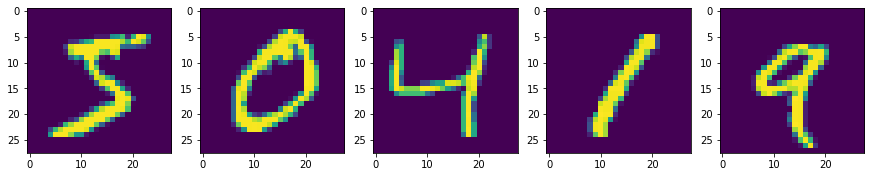

In [20]:
# To check shapes of the data
print("Size of X train: ", X_train.shape) # (60000, 784) 
print("Size of y train: ", y_train.shape) # (60000, 10)
print("Size of X test: ", X_test.shape) # (10000, 784) 
print("Size of y test: ", y_test.shape) # (10000, 10)

# These lines will show first 5 images of the training X data
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=5, figsize=(15,5))
for i in range(5): axes[i].imshow(X_train[i].reshape(28,28))
plt.show()

In [23]:
def accuracy(y_hat, y):
    assert y_hat.shape == y.shape, "y_hat and y must have the same shape"
    y_hat = y_hat.argmax(axis=1)
    y = y.argmax(axis=1)
    
    return (y_hat == y).mean()

## (a) Implement wide network

In [25]:
history, kept_params = gradient_descent_wide(X_train, y_train, epochs=10, batch_size=32, learning_rate=0.05, 
                                             acc_to_keep_params=0.97)

epoch 0, loss=0.15415,  acc=0.95157
epoch 1, loss=0.10996,  acc=0.96640
epoch 2, loss=0.09057,  acc=0.97093
epoch 3, loss=0.08161,  acc=0.97328
epoch 4, loss=0.07097,  acc=0.97700
epoch 5, loss=0.06061,  acc=0.98022
epoch 6, loss=0.04902,  acc=0.98402
epoch 7, loss=0.04325,  acc=0.98557
epoch 8, loss=0.03651,  acc=0.98783
epoch 9, loss=0.03842,  acc=0.98668


In [26]:
W_h1, W_o = kept_params["weight"]
b_h1, b_o = kept_params["bias"]

y_pred_test = predict_wide(X_test, W_h1, b_h1, W_o, b_o)

loss_test = cross_entropy(y_pred_test, y_test)
acc_test = accuracy(y_pred_test, y_test)

print("Test loss: %0.5f" %loss_test)
print("Test accuracy: %0.5f" %acc_test)

Test loss: 0.12479
Test accuracy: 0.96390


Text(0, 0.5, 'train loss')

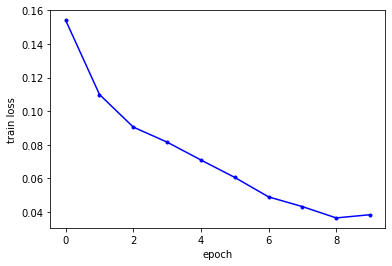

In [27]:
loss_train = history["loss"]
epochs = np.arange(len(loss_train))

plt.plot(epochs, loss_train, "b-", marker=".")
plt.xlabel("epoch")
plt.ylabel("train loss")

## (b) Implement deep network

In [29]:
history, kept_params = gradient_descent_deep(X_train, y_train, epochs=10, batch_size=32, learning_rate=0.05, 
                                             acc_to_keep_params=0.97)

epoch 0, loss=0.20818,  acc=0.93515
epoch 1, loss=0.15238,  acc=0.95275
epoch 2, loss=0.12951,  acc=0.96023
epoch 3, loss=0.10959,  acc=0.96528
epoch 4, loss=0.10070,  acc=0.96980
epoch 5, loss=0.09688,  acc=0.96988
epoch 6, loss=0.10757,  acc=0.96618
epoch 7, loss=0.09672,  acc=0.96982
epoch 8, loss=0.09380,  acc=0.96950
epoch 9, loss=0.09251,  acc=0.97078


In [30]:
W_h1, W_h2, W_o = kept_params["weight"]
b_h1, b_h2, b_o = kept_params["bias"]

y_pred_test = predict_deep(X_test, W_h1, b_h1, W_h2, b_h2, W_o, b_o)

loss_test = cross_entropy(y_pred_test, y_test)
acc_test = accuracy(y_pred_test, y_test)

print("Test loss: %0.5f" %loss_test)
print("Test accuracy: %0.5f" %acc_test)

Test loss: 0.15827
Test accuracy: 0.95400


Text(0, 0.5, 'train loss')

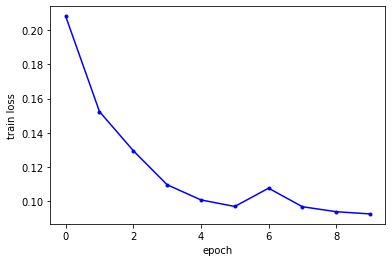

In [31]:
loss_train = history["loss"]
epochs = np.arange(len(loss_train))

plt.plot(epochs, loss_train, "b-", marker=".")
plt.xlabel("epoch")
plt.ylabel("train loss")

## (c) Number of parameters

In [32]:
# For wide network
(784 * 64) + 64 + (64 * 10) + 10

50890

In [33]:
# For deep network
(784 * 32) + 32 + (32 * 32) + 32 + (32 * 10) + 10

26506

The deep network uses less parameters than the wide one. Without optimizing hyperparameters, the wide network seems to give better test accuracy than the deep one. But in general deep networks are more efficient than wide ones in terms of reducing the number of parameters and still achiving the same accuracy. The reason is that deep networks are better at capturing hierarchical patterns in the data.